# python mcmc module  

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})

import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


#  data generating

In [6]:
np.random.seed(123)

alpha, sigma = 1, 1
beta = [1, 2.5]
size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Text(0.5, 0, 'X2')

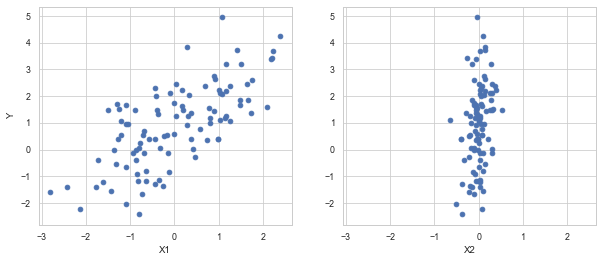

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2')

# PyMC3

In [8]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [9]:
# default optimization method is ""BFGS" implemented in scipy.optimize module.
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 843.55it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

In [10]:
# can shooce "powell" method
map_estimate = pm.find_MAP(model=basic_model, method='powell')

map_estimate

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/optimize/_minimize.py:502: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -149.47, ||grad|| = 13.248: 100%|██████████| 177/177 [00:00<00:00, 625.79it/s] 


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

# sampling method

In [11]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1168.07draws/s]


In [14]:
trace['alpha'][-5:]

array([0.87790689, 0.90878358, 0.82770494, 1.00444261, 0.94143866])

##  sampling slice 

In [15]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [00:13<00:00, 903.12draws/s] 


/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c22c09278>,
      dtype=object)

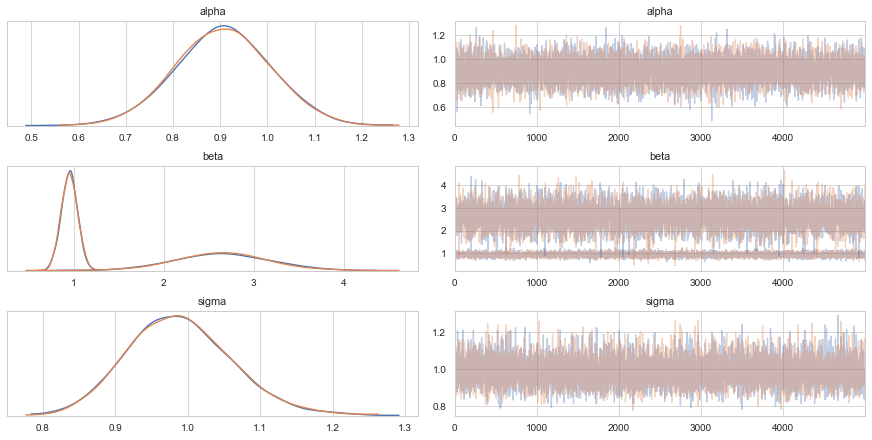

In [16]:
pm.traceplot(trace)

In [21]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.10,0.72,1.09,0.00,0.0,9287.0,9287.0,9308.0,6748.0,1.0
beta[0],0.95,0.09,0.77,1.11,0.00,0.0,10346.0,10290.0,10350.0,7219.0,1.0
beta[1],2.64,0.51,1.67,3.62,0.01,0.0,7481.0,7201.0,7506.0,5688.0,1.0
sigma,0.99,0.07,0.85,1.12,0.00,0.0,8330.0,8239.0,8443.0,6976.0,1.0


#  case study

In [25]:
returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)
len(returns)
returns.head()

,Close,change
Date,,
2008-05-02,1413.900024,0.003230
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663


Text(0, 0.5, 'daily returns in %')

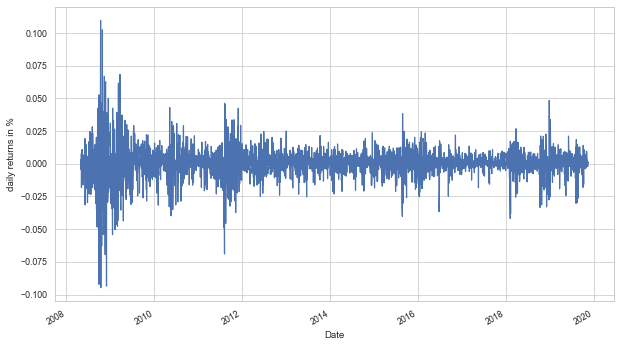

In [27]:
returns["change"].plot(figsize=(10, 6))
plt.ylabel('daily returns in %')

In [30]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sigma=volatility_process, observed=returns['change'])

In [31]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [08:44<00:00,  7.36draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


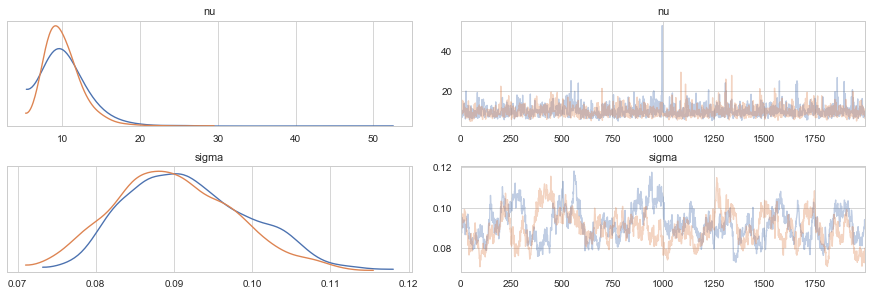

In [33]:
pm.traceplot(trace, var_names=['nu', 'sigma']);

/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/Toshiaki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


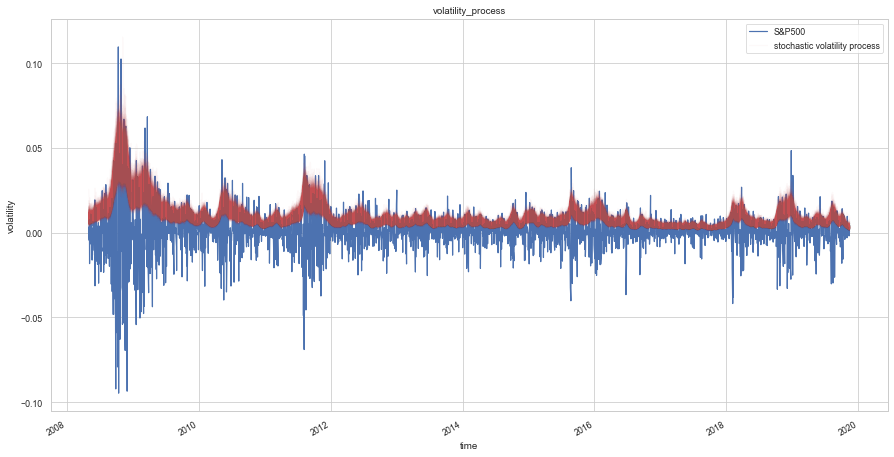

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))
returns["change"].plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03)
ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'stochastic volatility process'])